# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
!pip install --upgrade pandas

Requirement already up-to-date: pandas in /opt/conda/lib/python3.6/site-packages (1.1.5)


In [57]:
import pandas as pd
import numpy as np
import math
import json
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py

% matplotlib inline

#libraries for using machine learning algorithm 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier



# Data Extraction
Data extraction is the process of collecting or retrieving disparate types of data from a variety of sources, many of which may be poorly organized or completely unstructured. Data extraction makes it possible to consolidate, process, and refine data so that it can be stored in a centralized location in order to be transformed. These locations may be on-site, cloud-based, or a hybrid of the two.

Data extraction is the first step in both ETL (extract, transform, load) and ELT (extract, load, transform) processes. ETL/ELT are themselves part of a complete data integration strategy.


In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

df_transcript = transcript
df_profile = profile
df_portfolio = portfolio

##  Data Exploration and Data Analysis

Let start this project off, by exploring the dataset. To understand, what each column and datatype represents.

In [4]:
df_transcript.head(3)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0


In [5]:

# unique gives the information about the values in the particular column
df_transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [6]:
df_transcript.shape

(306534, 4)

In [7]:
df_profile.shape

(17000, 5)

In [8]:
df_portfolio.shape

(10, 6)

In [9]:
df_portfolio.head(3)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed


In [10]:
df_profile.head(3)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN


While exploring the data, its evident that all 3 datasets have a common parameter that we could use to merge and build into 1 dataset. Although the datasets are unequal in length, there are ways to merge the files. Which we will do in next.

# Data Wrangling & Data Cleaning  

Data Wrangling or Data munging is the practice of converting cleansed data into the dimensional model for a particular business case. It harmonizes the data and ensures quality assurance.

Data cleaning has a wide range of benefits that come with cleaning data that can lead to increased operational efficiency. Properly cleansing your data before use leads to benefits such as:

* Elimination of errors 
* Reduced costs associated with errors
* Improves the integrity of data
* Ensures the highest quality of information for decision making


In [11]:
#one hot encoding the portfoloio dataset
df_pof = df_portfolio
df_pof['email']= df_portfolio['channels'].astype(str).str.contains('email').astype(int)
df_pof['web']=df_portfolio['channels'].astype(str).str.contains('web').astype(int)
df_pof['mobile']=df_portfolio['channels'].astype(str).str.contains('mobile').astype(int)
df_pof['social']=df_portfolio['channels'].astype(str).str.contains('social').astype(int)
df_pof.drop(['channels'],axis=1,inplace=True)
df_pof = pd.concat([df_pof.drop('offer_type', axis=1), pd.get_dummies(df_portfolio['offer_type'])], axis=1)
df_pof.head(11)

,reward,difficulty,duration,id,email,web,mobile,social,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,0,1,1,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,1,0


In [12]:
df_portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [13]:
# this is part of data cleaning and wrangling on the transcript data

new = df_transcript['value'].astype(str).str.strip('{}').str.split(":", n=0, expand =True)
data = df_transcript
new['value'] = df_transcript.value
new = pd.DataFrame(new['value'].values.tolist(), index=new.index)
new.tail(3)


,offer id,amount,offer_id,reward
306531,NaN,3.61,NaN,NaN
306532,NaN,3.53,NaN,NaN
306533,NaN,4.05,NaN,NaN


In [14]:
# merge the updated data
data = pd.concat([data,new], axis =1)#
data.head(3)


,person,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN


In [15]:
#drop the value column, as its be seperated and enconded to seperate columns
data.drop(['value'], axis=1, inplace=True)
data.head(3)

,person,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN


In [16]:
#info gives the insite to the data, both data type as well as the null
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   person    306534 non-null  object 
 1   event     306534 non-null  object 
 2   time      306534 non-null  int64  
 3   offer id  134002 non-null  object 
 4   amount    138953 non-null  float64
 5   offer_id  33579 non-null   object 
 6   reward    33579 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 16.4+ MB



### Filling missing values 
Most of the machine learning models that you want to use will provide an error if you pass NaN values into it. The easiest way is to just fill them up with 0, but this can reduce your model accuracy significantly.

For filling missing values, there are many methods available. For choosing the best method, you need to understand the type of missing value and its significance, before you start filling/deleting the data.


In [17]:
# Since the there were 2 offer id columns, for the same purpose, the data needs to be combined 
#where there is NaN, and the other column should be deleted.
new_df = data
new_df["offer_id"] = np.where(new_df["offer_id"].isna(),new_df["offer id"],new_df["offer_id"])
new_df =new_df.drop("offer id",axis=1)
new_df.tail(3)

,person,event,time,amount,offer_id,reward
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,NaN,NaN
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,714,4.05,NaN,NaN



###  Identifying and Removing Duplicate values from dataset

An important part of Data analysis is analyzing Duplicate Values and removing them. Pandas drop_duplicates() method helps in removing duplicates from the data frame.

In [18]:
#check for duplicates, and remove if there is any
df_profile.duplicated().sum()

0

In [19]:

#check for duplicated value
new_df.duplicated().sum()

397

In [20]:
#remove duplicates, just keeping the first and verify if all are removed
new_df.drop_duplicates(keep = 'first', inplace = True)
new_df.duplicated().sum()

0

### Filling missing values - Part 2

In [21]:
def create_dict_replace_null(df, df2, l1):
    """
    This function, used the df2 to dict, to map and convert some of the NaN to a 
    appropriate values on the new df
    
    input: the df to change, df2 the dataset to be used as the dict,
        List of variables, that needs to be updated for NaN 
        
    output: 
    """
    for i in list(l1):
        d= df2.set_index('offer_id')[i].to_dict()
        df[i] = df[i].fillna(df.offer_id.map(d))

    df.info()
    return df

list_1 = ['reward']
new_df = create_dict_replace_null(new_df, df_portfolio, list_1)

new_df.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306137 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   person    306137 non-null  object 
 1   event     306137 non-null  object 
 2   time      306137 non-null  int64  
 3   amount    138953 non-null  float64
 4   offer_id  167184 non-null  object 
 5   reward    167184 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 16.3+ MB


,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,2.0


In [22]:
#check the null values in the reward
new_df['reward'].isna().sum()

138953

In [23]:
#fill all other NaN will 0
new_df.update(new_df[['reward','amount']].fillna(0))
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306137 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   person    306137 non-null  object 
 1   event     306137 non-null  object 
 2   time      306137 non-null  int64  
 3   amount    306137 non-null  float64
 4   offer_id  167184 non-null  object 
 5   reward    306137 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 16.3+ MB


In [24]:
# filling with NaN with the Unknown class for the profile dataset
df1_profile = df_profile
df1_profile['gender'] =df1_profile['gender'].fillna("Unknown")
#filling the Nan with the value that comes before
df1_profile['income'] =df1_profile['income'].fillna(method ="ffill")


### Data Merge
The Pandas method for joining two DataFrame objects is merge(), which is the single entry point for all standard database join operations between DataFrame or named Series objects. (Series objects are one-dimensional.) 


In [25]:
#rename any common parameter, before merging
df1_profile.rename(columns={'id': 'person'}, inplace=True)

In [26]:
# Merge transactions and profile datasets after cleaning the dataset.
merge_df = new_df
merge_df = merge_df.merge(df1_profile, how='left')
merge_df.head(3)

,person,event,time,amount,offer_id,reward,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,F,75,20170509,100000.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,Unknown,118,20170804,100000.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,2906b810c7d4411798c6938adc9daaa5,2.0,M,68,20180426,70000.0


In [27]:
merge_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 306137 entries, 0 to 306136
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   person            306137 non-null  object 
 1   event             306137 non-null  object 
 2   time              306137 non-null  int64  
 3   amount            306137 non-null  float64
 4   offer_id          167184 non-null  object 
 5   reward            306137 non-null  float64
 6   gender            306137 non-null  object 
 7   age               306137 non-null  int64  
 8   became_member_on  306137 non-null  int64  
 9   income            306116 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usage: 25.7+ MB


As you can see there is no more null values in the combined data set. The data is good to go for the next level merging the portfolio dataset.

In [28]:
# merge the portfolio with the main merged dataset
merge_df1 = merge_df.merge(df_portfolio,how='left',on='offer_id')

In [29]:
#remove duplicated columns...
merge_df2 = merge_df1.drop(['reward_x','reward_y'],axis=1,inplace=False)
#sort events by person and time, this is necessary to find which offer was successful
merge_df2=merge_df2.sort_values(['person','time'])
merge_df2.head()

,person,event,time,amount,offer_id,gender,age,became_member_on,income,difficulty,duration,offer_type,email,web,mobile,social
55972,0009655768c64bdeb2e877511632db8f,offer received,168,0.00,5a8bc65990b245e5a138643cd4eb9837,M,33,20170421,72000.0,0.0,3.0,informational,1.0,0.0,1.0,1.0
77699,0009655768c64bdeb2e877511632db8f,offer viewed,192,0.00,5a8bc65990b245e5a138643cd4eb9837,M,33,20170421,72000.0,0.0,3.0,informational,1.0,0.0,1.0,1.0
89279,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,NaN,M,33,20170421,72000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113591,0009655768c64bdeb2e877511632db8f,offer received,336,0.00,3f207df678b143eea3cee63160fa8bed,M,33,20170421,72000.0,0.0,4.0,informational,1.0,1.0,1.0,0.0
139973,0009655768c64bdeb2e877511632db8f,offer viewed,372,0.00,3f207df678b143eea3cee63160fa8bed,M,33,20170421,72000.0,0.0,4.0,informational,1.0,1.0,1.0,0.0


### Filling Missing Values - Part 3

The merging has led  to few more columns with the NaN values.
Offer_id for the event transaction, is missing. But this missing value is the key. so must be carefully filled 
after rearranging the dataset based person and offer_id assosiated with that person, provided the event is either the offer_viewed, or transaction.


In [30]:
#filter dataset for transactions that occur after an offer is viewed, forward fill offer ids by person
df_offer = merge_df2
df_offer['offer_id']= merge_df2.groupby([(merge_df2['event']=='transaction') | (merge_df2['event']=='offer viewed')])['offer_id'].ffill()
df_offer.head()

,person,event,time,amount,offer_id,gender,age,became_member_on,income,difficulty,duration,offer_type,email,web,mobile,social
55972,0009655768c64bdeb2e877511632db8f,offer received,168,0.00,5a8bc65990b245e5a138643cd4eb9837,M,33,20170421,72000.0,0.0,3.0,informational,1.0,0.0,1.0,1.0
77699,0009655768c64bdeb2e877511632db8f,offer viewed,192,0.00,5a8bc65990b245e5a138643cd4eb9837,M,33,20170421,72000.0,0.0,3.0,informational,1.0,0.0,1.0,1.0
89279,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,5a8bc65990b245e5a138643cd4eb9837,M,33,20170421,72000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113591,0009655768c64bdeb2e877511632db8f,offer received,336,0.00,3f207df678b143eea3cee63160fa8bed,M,33,20170421,72000.0,0.0,4.0,informational,1.0,1.0,1.0,0.0
139973,0009655768c64bdeb2e877511632db8f,offer viewed,372,0.00,3f207df678b143eea3cee63160fa8bed,M,33,20170421,72000.0,0.0,4.0,informational,1.0,1.0,1.0,0.0


In [31]:
#Use the portfolio as a dict and fill in the NaN values, with valid value.
list_1 = ['offer_type','mobile','email','social', 'web', 'difficulty', 'duration']
merge_df2 = create_dict_replace_null(df_offer, df_portfolio, list_1)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 306137 entries, 55972 to 289552
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   person            306137 non-null  object 
 1   event             306137 non-null  object 
 2   time              306137 non-null  int64  
 3   amount            306137 non-null  float64
 4   offer_id          306137 non-null  object 
 5   gender            306137 non-null  object 
 6   age               306137 non-null  int64  
 7   became_member_on  306137 non-null  int64  
 8   income            306116 non-null  float64
 9   difficulty        306137 non-null  float64
 10  duration          306137 non-null  float64
 11  offer_type        306137 non-null  object 
 12  email             306137 non-null  float64
 13  web               306137 non-null  float64
 14  mobile            306137 non-null  float64
 15  social            306137 non-null  float64
dtypes: float64(8), i

In [32]:
merge_df2.update(merge_df2['income'].fillna(0))
merge_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306137 entries, 55972 to 289552
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   person            306137 non-null  object 
 1   event             306137 non-null  object 
 2   time              306137 non-null  int64  
 3   amount            306137 non-null  float64
 4   offer_id          306137 non-null  object 
 5   gender            306137 non-null  object 
 6   age               306137 non-null  int64  
 7   became_member_on  306137 non-null  int64  
 8   income            306137 non-null  float64
 9   difficulty        306137 non-null  float64
 10  duration          306137 non-null  float64
 11  offer_type        306137 non-null  object 
 12  email             306137 non-null  float64
 13  web               306137 non-null  float64
 14  mobile            306137 non-null  float64
 15  social            306137 non-null  float64
dtypes: float64(8), i

In [33]:
merge_df2.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15501
                 discount         17681
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
transaction      bogo             62188
                 discount         57043
                 informational    19722
Name: offer_type, dtype: int64


## Statistical analysis
Statistical techniques can help us find correlations between various features of data and target relationships between those features, leading to a better understanding of the problem to be solved.
With a better understanding of a dataset, it’s easy to analyze and summarize it, as well as extract insights from complex information.
Statistical techniques allow users to make predictions for unseen data, more easily improving the accuracy of output and results.


In [34]:
merge_df2['gender'].value_counts()

M          155483
F          112940
Unknown     33749
O            3965
Name: gender, dtype: int64

In [35]:
#returns the mean, max, average values
merge_df2.describe()

,time,amount,age,became_member_on,income,difficulty,duration,email,web,mobile,social
count,306137.000000,306137.000000,306137.000000,3.061370e+05,306137.000000,306137.000000,306137.000000,306137.0,306137.000000,306137.000000,306137.000000
mean,366.185015,5.799534,60.911817,2.016545e+07,64526.940553,7.732953,6.603419,1.0,0.792786,0.937459,0.712586
std,200.348174,21.349948,26.036284,1.190569e+04,21310.055464,4.719633,2.138489,0.0,0.405311,0.242135,0.452557
min,0.000000,0.000000,18.000000,2.013073e+07,0.000000,0.000000,3.000000,1.0,0.000000,0.000000,0.000000
25%,186.000000,0.000000,43.000000,2.016032e+07,48000.000000,5.000000,5.000000,1.0,1.000000,1.000000,0.000000
50%,408.000000,0.000000,57.000000,2.017041e+07,62000.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000
75%,528.000000,7.130000,72.000000,2.017113e+07,78000.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000
max,714.000000,1062.280000,118.000000,2.018073e+07,120000.000000,20.000000,10.000000,1.0,1.000000,1.000000,1.000000




# Data Visualisation

Data visualization in python is perhaps one of the most utilized features for data science with python in today’s day and age. The libraries in python come with lots of different features that enable users to make highly customized, elegant, and interactive plots.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0987559470>,
      dtype=object)

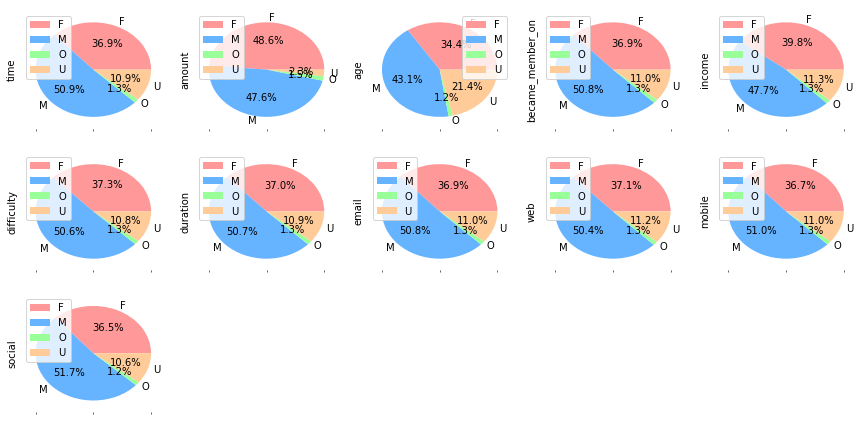

In [36]:
## Pie chart based on gender
#add colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
my_explode=(0.2,0,0.1,0)

merge_df2.groupby(['gender']).sum().plot(kind='pie', subplots=True,
figsize=(15,10), autopct='%1.1f%%', sort_columns = True, colors=colors, layout = (4,5), labels= 'FMOU')

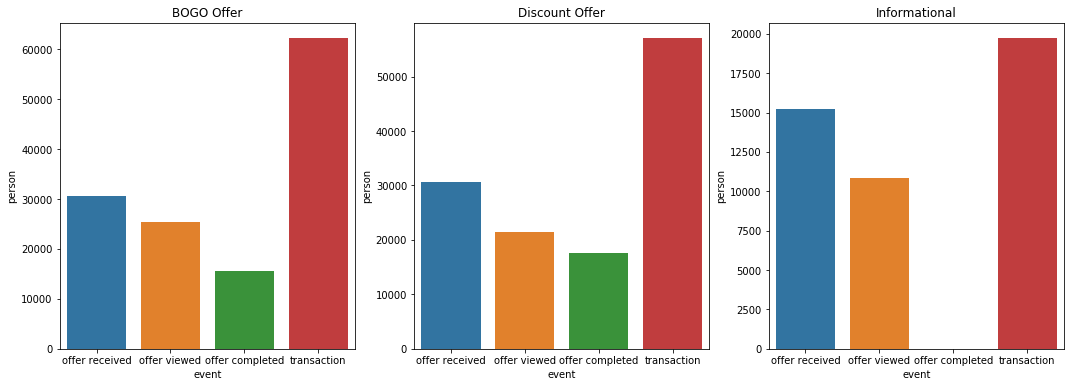

In [37]:
#Visual represenattion of offer type performance
vis_df1 = merge_df2.groupby(['event', 'offer_type'])['person']

vis_df1=vis_df1.count().reset_index()
vis_df1['event'] = pd.Categorical(vis_df1['event'], ["offer received", "offer viewed", "offer completed", "transaction"])
vis_df1.sort_values('event', inplace=True)

fig, xyz = plt.subplots(ncols=3, figsize=(18, 6))

ax = sns.barplot('event','person', data=vis_df1.query('offer_type == "bogo"'),  ax=xyz[0])
ax.set(title='BOGO Offer')


ax = sns.barplot('event','person', data=vis_df1.query('offer_type == "discount"'), ax=xyz[1])
ax.set(title='Discount Offer')

ax = sns.barplot('event','person', data=vis_df1.query('offer_type == "informational"'),ax=xyz[2])
ax.set(title='Informational');

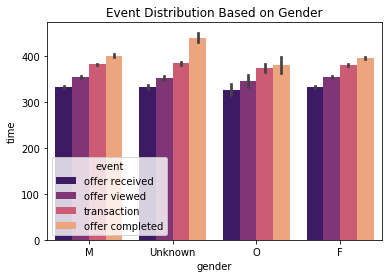

In [38]:
#plot barchart for gender ,time and offer 
gen_in_off = sns.barplot(x='gender', y='time',hue='event', data=merge_df2, palette="magma")
gen_in_off.set(xlabel='gender', ylabel='time')
gen_in_off.set_title('Event Distribution Based on Gender');

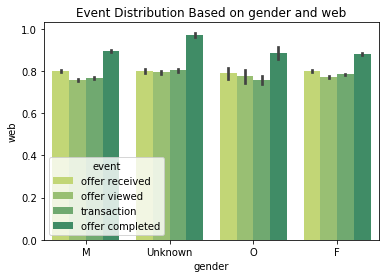

In [39]:
#plot barchart for gender ,web and offer 
gen_in_off = sns.barplot(x='gender', y='web',hue='event', data=merge_df2, palette="summer_r")
gen_in_off.set(xlabel='gender', ylabel='web')
gen_in_off.set_title('Event Distribution Based on gender and web');

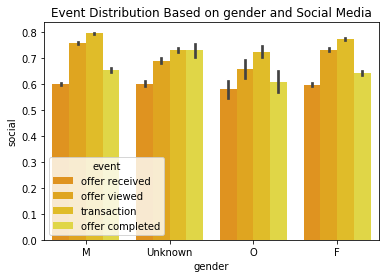

In [40]:
#plot barchart for gender ,web and offer 
gen_in_off = sns.barplot(x='gender', y='social',hue='event', data=merge_df2, palette="Wistia_r")
gen_in_off.set(xlabel='gender', ylabel='social')
gen_in_off.set_title('Event Distribution Based on gender and Social Media');

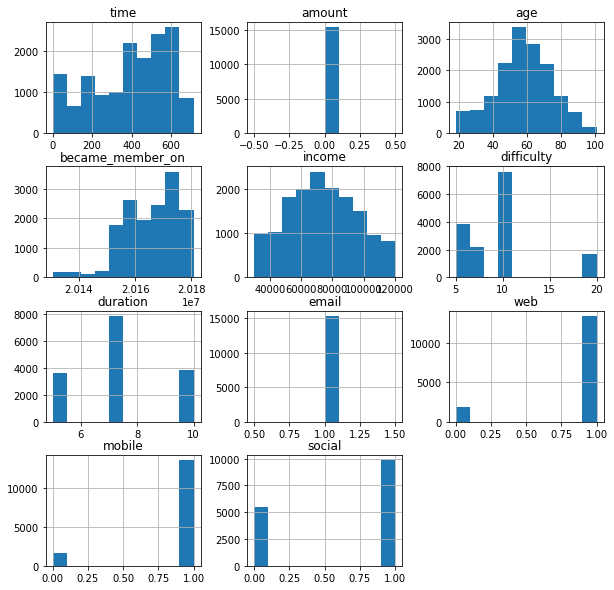

In [41]:
train_data = merge_df2
train_data[(train_data['gender']=='F') & (train_data['event'] =='offer completed') ].hist(figsize=(10,10));

The offer is set to complete in both the cases where the customers were sent the Offer, some were viewed, and the transaction was made. Where some were not viewed, yet bought and completed the offer. Based on the figure, one of the points is evident Median age group is around 50–60 having an income range of 60–80k, which may be a good target to invite more revenue.



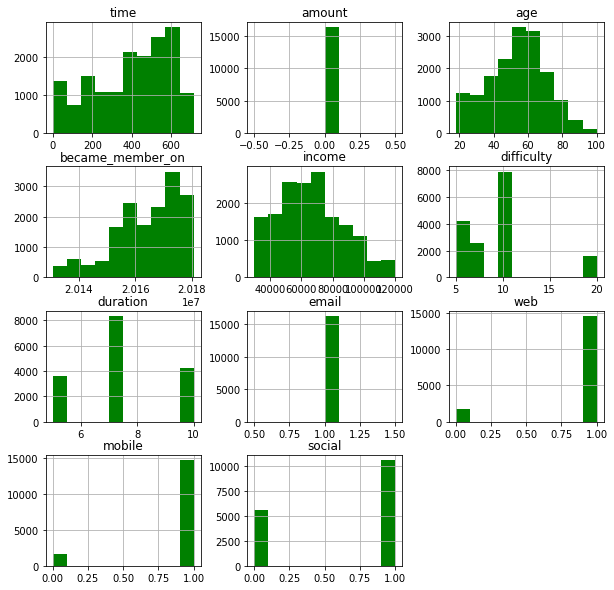

In [42]:
train_data[(train_data['gender']=='M') & (train_data['event'] =='offer completed') ].hist(figsize=(10,10), color='green');

Comparing the results with the Female group of ppl. The male group of ppl has received offers through the channel of Email, Web, Mobile, Social media higher than the count noted in the Female histogram chart. The more personal invitation could be one of the reasons, the group of males was higher in count who purchased the offer compared to the all other gender.




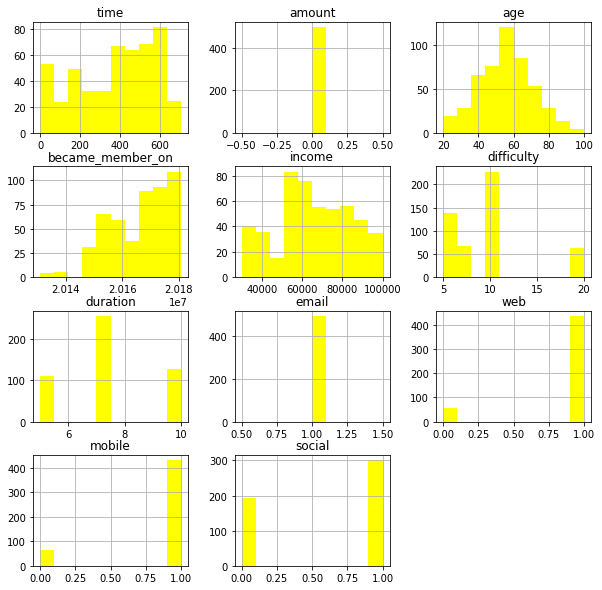

In [43]:
train_data[(train_data['gender']=='O') & (train_data['event'] =='offer completed') ].hist(figsize=(10,10), color='yellow');

In [44]:
merge_df2.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33182
Name: event, dtype: int64

### Column into categorical variables

In [45]:
#drop  dummy gender variable 
df = pd.concat([merge_df2.drop('gender', axis=1), pd.get_dummies(merge_df2['gender'])], axis=1)

#drop  dummy event variable 
df1 = pd.concat([df.drop('event', axis=1), pd.get_dummies(df['event'])], axis=1)

#drop  dummy offer_type variable 
df2 = pd.concat([df1.drop('offer_type', axis=1), pd.get_dummies(df1['offer_type'])], axis=1)
df1.head(3)

,person,time,amount,offer_id,age,became_member_on,income,difficulty,duration,offer_type,...,mobile,social,F,M,O,Unknown,offer completed,offer received,offer viewed,transaction
55972,0009655768c64bdeb2e877511632db8f,168,0.00,5a8bc65990b245e5a138643cd4eb9837,33,20170421,72000.0,0.0,3.0,informational,...,1.0,1.0,0,1,0,0,0,1,0,0
77699,0009655768c64bdeb2e877511632db8f,192,0.00,5a8bc65990b245e5a138643cd4eb9837,33,20170421,72000.0,0.0,3.0,informational,...,1.0,1.0,0,1,0,0,0,0,1,0
89279,0009655768c64bdeb2e877511632db8f,228,22.16,5a8bc65990b245e5a138643cd4eb9837,33,20170421,72000.0,0.0,3.0,informational,...,1.0,1.0,0,1,0,0,0,0,0,1


### Heat Map

Heatmap is a data visualization technique, which represents data using different colours in two dimensions. In Python, we can create a heatmap using matplotlib and seaborn library. Although there is no direct method using which we can create heatmaps using matplotlib, we can use the matplotlib imshow function to create heatmaps.  

In a Matplotlib heatmap, every value (every cell of a matrix) is represented by a different color. Data Scientists generally use heatmaps when they want to understand the correlation between various features of a data frame. 

sns is used for our illustration

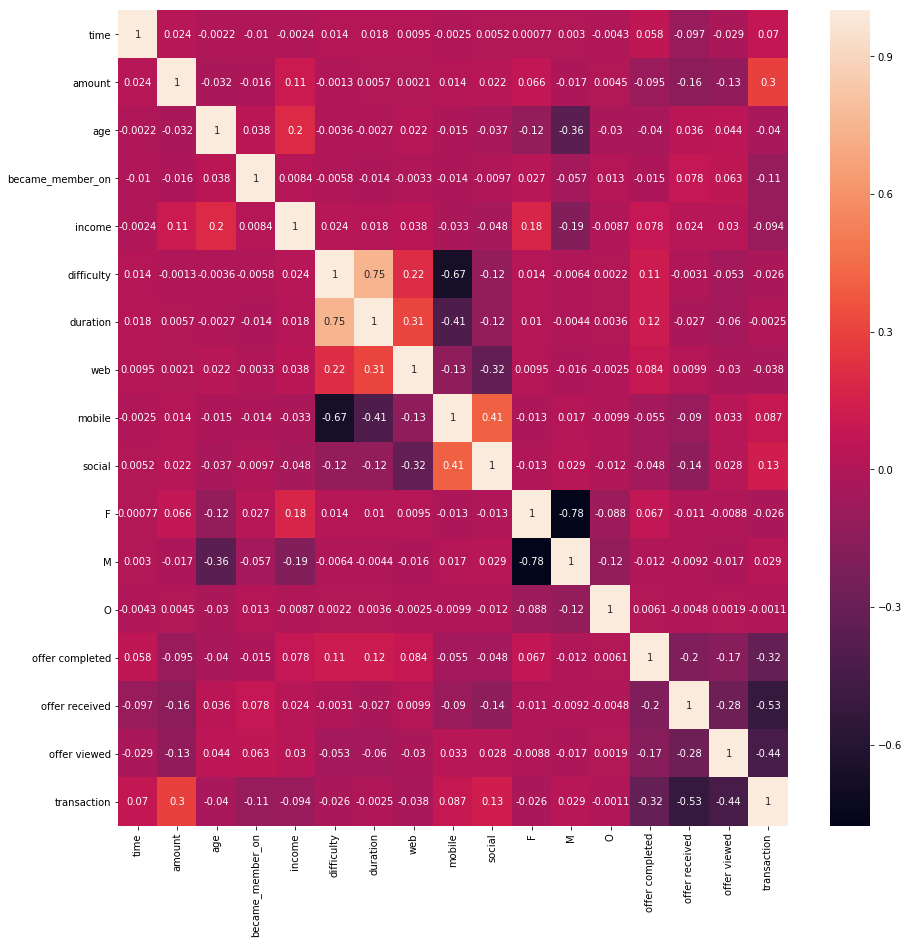

In [46]:
df2 = df1.drop(['person', 'Unknown', 'offer_id', 'email'],axis=1)

Var_Corr = df2.corr()

# plot the heatmap and annotation on it
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True,ax=ax)

The Correlation gives away lots of speculation, which is possible. 

* The Gender other than Female and male, are quite closer to female.
* Around 32% of transactions, says the offer has been used .
* Women received equal number of offers through mobile, and social media.
* Whereas Men received more through social media compared to Mobile or web.

The more we analyze this heatmap correlation, the more predictions could be confirmed by just by reading the correlated values.

## Train and Test

In [47]:
X=df1.drop(['person','offer_type','offer_id','offer completed','Unknown', 'email', 'social', 'O'],axis=1)
y=df1['offer completed']
#changing the y classes to either success or failure only instead of the count
#y[y>1]=1
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=.20, random_state=42)

The category Unknown, can be dropped off, as they dont seem to care about the offers. They will buy, even if they dont receive


In [48]:
# Spot-Check Algorithms
def GetBasedModel():
    """
    This function creates a list of different ML models to use
    for predicting accuracy.
    Input: None
    Output: base models list
    """
    basedModels = []
    basedModels.append(('LR'   , LogisticRegression()))
    basedModels.append(('LDA'  , LinearDiscriminantAnalysis()))
    basedModels.append(('KNN'  , KNeighborsClassifier()))
    basedModels.append(('CART' , DecisionTreeClassifier()))
    basedModels.append(('NB'   , GaussianNB()))
    #basedModels.append(('SVM'  , SVC(probability=True)))
    basedModels.append(('AB'   , AdaBoostClassifier()))
    basedModels.append(('GBM'  , GradientBoostingClassifier()))
    basedModels.append(('RF'   , RandomForestClassifier()))
    basedModels.append(('ET'   , ExtraTreesClassifier()))

    
    return basedModels

In [49]:
def BasedLine2(X_train, y_train,models):
    
    """
    This function used the model passed as a parameter with X, Y parameter
    to process and generate scores.
    
    input: X value, Y value, and the model to use for processing
    
    output: names of the model processed along with the results.
    
    """
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'accuracy'
    SEED = 7

    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=num_folds, random_state=SEED)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

In [53]:
class PlotBoxR(object):
    
    """
    This class is used for the Box plot, visualise and compare data for 
    each processed data.
    """
    def __Trace(self,nameOfFeature,value): 
        """
        creates the trace with the name and color code is added
        
        input : name of the features and its assosiated value for plotting
        
        Output: trace
        
        """
    
        trace = go.Box(
            y=value,
            name = nameOfFeature,
            marker = dict(
                color = 'rgb(0, 128, 128)',
            )
        )
        return trace

    def PlotResult(self,names,results):
        """
        creates the trace with the name and color code is added
        
        input : name of the features and its assosiated value for plotting
        
        Output: trace
        
        """       
        data = []

        for i in range(len(names)):
            data.append(self.__Trace(names[i],results[i]))


        py.iplot(data)

In [60]:
models = GetBasedModel()
names,results = BasedLine2(x_train, y_train,models)


LR: 0.891817 (0.000016)


/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.

/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.

/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.

/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.

/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.

/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.

/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.

/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.

/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_anal

LDA: 0.891817 (0.000016)
KNN: 0.884169 (0.000735)
CART: 1.000000 (0.000000)
NB: 0.642222 (0.003773)
AB: 1.000000 (0.000000)
GBM: 1.000000 (0.000000)
RF: 1.000000 (0.000000)
ET: 1.000000 (0.000000)


In [61]:
PlotBoxR().PlotResult(names,results)

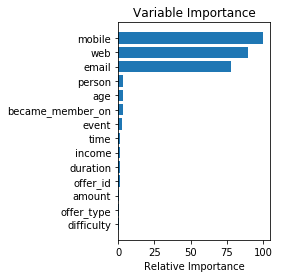

In [65]:
clf = ExtraTreesClassifier(n_estimators=250, random_state=7)

clf.fit(x_train, y_train)

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()